In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii
import pandas as pd
import astropy.constants as ac
import astropy.units as u

In [ ]:
#give colab access to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Sodium 5890 and 5896 doublet arises from the 3p - 3s transition:

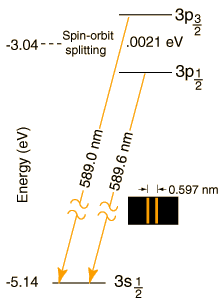

## Solar spectrum is from: http://bass2000.obspm.fr/solar_spect.php

In [ ]:
spec = astropy.io.ascii.read("/content/drive/My Drive/Colab Notebooks/solar_spectrum.txt")

In [ ]:
specdf = pd.DataFrame(data=spec.as_array())

mins = specdf.loc[specdf['col2'] < 1000]
print(mins)

          col1  col2
2198  5889.890   983
2199  5889.902   762
2200  5889.912   648
2201  5889.924   550
2202  5889.934   500
2203  5889.944   467
2204  5889.956   450
2205  5889.966   451
2206  5889.978   472
2207  5889.988   505
2208  5890.000   568
2209  5890.010   649
2210  5890.020   775
2748  5895.868   925
2749  5895.880   732
2750  5895.890   636
2751  5895.902   558
2752  5895.912   521
2753  5895.924   501
2754  5895.934   504
2755  5895.944   524
2756  5895.956   573
2757  5895.966   642
2758  5895.978   769
2759  5895.988   941


Text(0, 0.5, 'Normalized Flux')

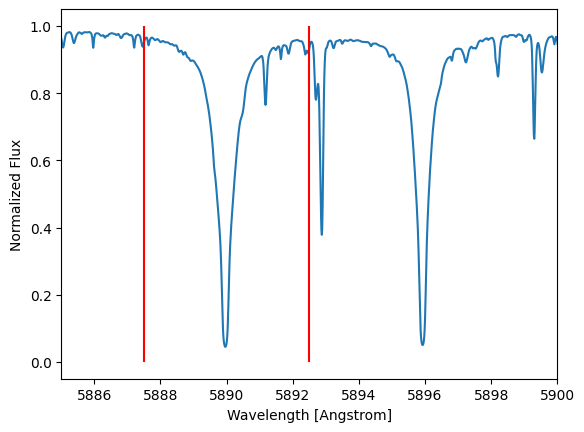

In [ ]:
plt.plot(spec["col1"], spec["col2"] / 1e4)
# plt.vlines(5887.5, 0, 10000, color="red")
# plt.vlines(5892.5, 0, 10000, color="red")
plt.vlines(5887.5, 0, 1, color="red")
plt.vlines(5892.5, 0, 1, color="red")
plt.xlim(5885, 5900)
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Normalized Flux")

## Equivalent width (ew) is defined as the width of a rectangle with a height equal to that of continuum emission such that the area of the rectangle is equal to the area in the spectral line.

In [ ]:
ind = np.where((spec["col1"] < 5892.5) & (spec["col1"] > 5887.5))
inc = np.median(np.diff(spec["col1"][ind]))
ew = np.sum(1e4 - spec["col2"][ind]) * inc / 1e4
print("equivalent width (ew) = ", ew, " Angstrom")

equivalent width (ew) =  0.8346720000182191  Angstrom


In [ ]:
np.log10(0.83 / 5890.0)

np.float64(-3.8510372024110278)

## Now find the number of Na atoms in absorbing state based on the following curve of growth plot:

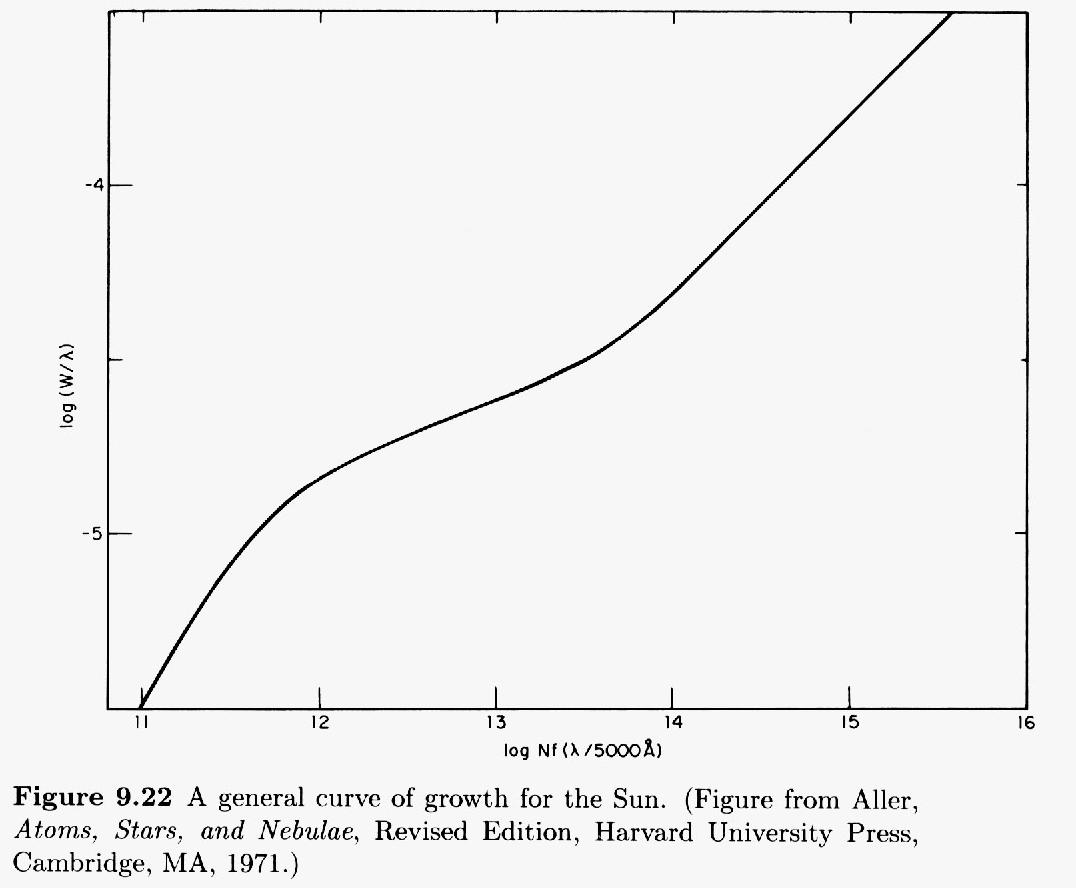

In [ ]:
10**14.8 / 0.65 / (5890 / 5000) / 1e14

8.240268309784437

## log(W/$\lambda$) = log(0.83 / 5890) = -3.85, where W is equivalent width.
## The corresponding value on x-axis is log(Nf($\lambda/5000\overset{\circ}{A}$))$\sim$14.8.
## Rearranged, we have N = $8.24\times10^{14}$ with the unit of atoms/cm$^2$, assuming f = 0.65, where f is the oscillator strength for this transition at 5890 $\overset{\circ}{A}$.

## Questions:
## 1, Estimate the ratio of sodium atoms in the ground state to sodium atoms in excited states using the Boltzmann equation:

## $\frac{N_2}{N_1} = \frac{g_2}{g_1}e^\left({-\frac{E_2 - E_1}{kT}}\right)$, where subscripts 1 and 2 refer to 3s and 3p states, $N$ is number density, $g$ is the number of separate, individual states that are degenerate in energy, $E$ is energy at the state, $k$ is Boltzmann constant, and $T$ is temperature.

In [ ]:
def boltzmann(g1, g2, Ediff, T):
  """
  Function will only work if energy is given in SI units

  """
  ratio = g2 / g1 * np.exp(-(Ediff) / (ac.k_B * T))
  return ratio

In [ ]:
# Estimating ratio of sodium atoms
# Values

g1 = 2
g2 = 6
Ediff = 2.107 * (1.60218e-19) * u.Joule
T = 5772 * u.Kelvin # Kelvin

boltzmann_ratio = boltzmann(g1, g2, Ediff, T)
print(boltzmann_ratio)

0.04339165958005825


## 2, Estimate the ratio of neutral sodium atoms to ionized sodium atoms. You will use the Saha equation:

## $\frac{Na_{II}}{Na_{I}} = \frac{2kT}{P_e} \frac{Z_{II}}{Z_I} \left(\frac{2\pi m_e kT}{h^2}\right)^{3/2}e^{\left(-\frac{\chi}{kT}\right)}$, where $m_e$ is electron mass, partition function $Z_I = 2.4$ and  $Z_{II} = 1.0$, electron pressure $P_e = n_e kT = 1.0 N\cdot m^{-2}$, and the ionization energy $\chi = 5.1$ eV. Note that the values given are for the sodium line only. Other lines have different values.

In [ ]:
def saha(z1, z2, chi, T, P_e):
  """
  Function only works if T is given in Kelvin (K)
  """
  a = 2 * ac.k_B * T / P_e
  b = z2 / z1 * (2 * np.pi * ac.m_e * ac.k_B * T / ac.h**2) ** (3/2)
  c = np.exp((-(chi * u.eV).to(u.Joule))  / (ac.k_B * T))

  ratio = a * b * c

  return ratio.decompose()

In [ ]:
# Estimating ratio of neutral sodium atoms to ionized sodium atoms

P_e = (1.0 * u.N * u.m**(-2))
z1 = 2.4
z2 = 1.0
chi = 5.1 #ev

ion_ratio = saha(z1, z2, chi, T, P_e)
print(ion_ratio)

2477.7159196603775


## 3, Compute the total column density of sodium atoms in the sun's photosphere, assuming the total number of sodium atoms equals to: $N_{1} \times (1+\frac{N_2}{N_1}) \times (1+\frac{Na_{II}}{Na_{I}}$). $N_1$ is measured from the curve of growth. The last two terms have been calculated in question 1 and 2.

In [ ]:
N1_sodium = (10**14.8 / 0.65 / (5890 / 5000) / 1e14) * (10**14)

def total_column_density(N1, boltzmann_ratio, ion_ratio):
  total_density = N1 * (1 + boltzmann_ratio) * (1 + ion_ratio)
  return total_density

density_sodium = total_column_density(N1_sodium, boltzmann_ratio, ion_ratio)
print(density_sodium)

2.1311571222378913e+18





## 4, The column density of hydrogen atoms is about $6.6\times10^{23}$; what is the abundance of sodium relative to hydrogen?

# This is what physicists use (the exact ratio).

In [ ]:
density_hydrogen = 6.6 * 10**23
exact_abundance = density_sodium / density_hydrogen
print(exact_abundance)

3.2290259427846843e-06


# For astronomers working on galaxies: $12 + log_{10}(N_{element}/N_{H})$, where N is in mole or number density.

In [ ]:
gal_relative_abundance = 12 + np.log10(density_sodium / density_hydrogen)
print(gal_relative_abundance)

6.509071534259333


# For astronomers working on stars they use the abundance relative to the Sun: $log_{10}(\frac{N_{element}/N_{H}}{(N_{element}/N_{H})_{\odot}})$

The official value from Palme et al. (2014) for the logarithmic abundance of Na is: $6.30$

=> $6.30 = 12 + log_{10}(N_{Na}/N_{H})$

=> $\frac{N_{Na}}{N_H} = 10^{(6.30 - 12)}$

In [ ]:
sun_exact_abundance = 10**(6.30 - 12)
print(sun_exact_abundance)

1.9952623149688787e-06


In [ ]:
sol_relative_abundance = np.log10((density_sodium / density_hydrogen)/(sun_exact_abundance))
print(sol_relative_abundance)

0.2090715342593338


# This is pretty close!

## \*\*\*Bonus***: try a different line from a different element, e.g., Mg, Si, or Fe, and see how close you can get to the solar value and explain the difference.

In [ ]:
spec = np.loadtxt("/content/drive/My Drive/Colab Notebooks/Mg5168.txt")

Text(0, 0.5, 'Flux')

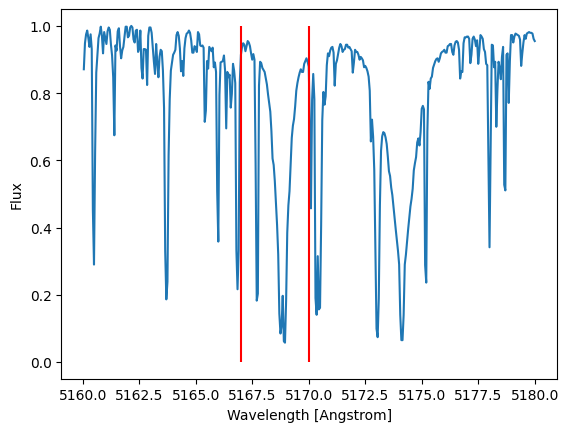

In [ ]:
wav = spec[:,0]
flx = spec[:,1]
plt.plot(wav, flx)
plt.vlines(5167.0, 0, 1, color="red")
plt.vlines(5170.0, 0, 1, color="red")
plt.xlabel("Wavelength [Angstrom]")
plt.ylabel("Flux")

In [ ]:
spec = astropy.io.ascii.read("/content/drive/My Drive/Colab Notebooks/Mg5168.txt")

In [ ]:
ind = np.where((spec["col1"] < 5180.0) & (spec["col1"] > 5170.0))
inc = np.median(np.diff(spec["col1"][ind]))
ew = np.sum(1e4 - spec["col2"][ind]) * inc / 1e4
print("equivalent width (ew) = ", ew, " Angstrom")

equivalent width (ew) =  9.910373875288617  Angstrom


In [ ]:
np.log10(ew / 5169.0)

np.float64(-2.7173164933320693)

In [ ]:
10**14.8 / 0.117 / (5167 / 5000) / 1e14

52.18499918782694

$52.16\times10^{14}$ with the unit of atoms/cm$^2$, assuming f = 0.117, where f is the oscillator strength for this transition at 5167 $\overset{\circ}{A}$.

## 1, Estimate the ratio of sodium atoms in the ground state to sodium atoms in excited states using the Boltzmann equation:

## $\frac{N_2}{N_1} = \frac{g_2}{g_1}e^\left({-\frac{E_2 - E_1}{kT}}\right)$, where subscripts 1 and 2 refer to 3s and 3p states, $N$ is number density, $g$ is the number of separate, individual states that are degenerate in energy, $E$ is energy at the state, $k$ is Boltzmann constant, and $T$ is temperature.

In [ ]:
# Estimating ratio of magnesium atoms
# Values

g1 = 2
g2 = 6
E3p = 12.08 #eV
E3s = 7.64 #eV
Ediff = (E3p - E3s) * (1.60218e-19) * u.Joule
T = 5772 * u.Kelvin # Kelvin

boltzmann_ratio = boltzmann(g1, g2, Ediff, T)
print(boltzmann_ratio)

0.000398437915941493


## 2, Estimate the ratio of neutral magnesium atoms to ionized magnesium atoms. You will use the Saha equation:

## $\frac{Mg_{II}}{Mg_{I}} = \frac{2kT}{P_e} \frac{Z_{II}}{Z_I} \left(\frac{2\pi m_e kT}{h^2}\right)^{3/2}e^{\left(-\frac{\chi}{kT}\right)}$, where $m_e$ is electron mass, partition function $Z_I = 1.0$ and  $Z_{II} = 1.0$, electron pressure $P_e = n_e kT = 0.001 N\cdot m^{-2}$, and the ionization energy $\chi = 7.6$ eV.




In [ ]:
# Estimating ratio of neutral magnesium atoms to ionized magnesium atoms

P_e = (10**(-2) * u.N * u.m**(-2))
z1 = 1.0
z2 = 1.0
z3 = 1.0
chi = 7.6 #ev

ion_ratio = saha(z1, z2, chi, T, P_e)
print(ion_ratio)

3903.072726033447


## 3, Compute the total column density of mg atoms in the sun's photosphere, assuming the total number of mg atoms equals to: $N_{1} \times (1+\frac{N_2}{N_1}) \times (1+\frac{Mg_{II}}{Mg_{I}}$). $N_1$ is measured from the curve of growth. The last two terms have been calculated in question 1 and 2.

In [ ]:
N1_mag = 10**14.8 / 0.117 / (5167 / 5000) / 1e14 * (10**14)

def total_column_density(N1, boltzmann_ratio, ion_ratio):
  total_density = N1 * (1 + boltzmann_ratio) * (1 + ion_ratio)
  return total_density

density_mag = total_column_density(N1_mag, boltzmann_ratio, ion_ratio)
print(density_mag)

2.03815207400404e+19


## 4, The column density of hydrogen atoms is about $6.6\times10^{23}$; what is the abundance of Mg relative to hydrogen?

# This is what physicists use (the exact ratio).

In [ ]:
density_hydrogen = 6.6 * 10**23
exact_abundance = density_mag / density_hydrogen
print(exact_abundance)

3.088109203036425e-05


# For astronomers working on galaxies: $12 + log_{10}(N_{element}/N_{H})$, where N is in mole or number density.

In [ ]:
gal_relative_abundance = 12 + np.log10(density_mag / density_hydrogen)
print(gal_relative_abundance)

7.489692649642183


# For astronomers working on stars they use the abundance relative to the Sun: $log_{10}(\frac{N_{element}/N_{H}}{(N_{element}/N_{H})_{\odot}})$

The official value from Palme et al. (2014) for the logarithmic abundance of Na is: $7.54$

=> $7.54 = 12 + log_{10}(N_{Na}/N_{H})$

=> $\frac{N_{Na}}{N_H} = 10^{(7.54 - 12)}$

In [ ]:
sun_exact_abundance = 10**(7.54 - 12)
print(sun_exact_abundance)

3.467368504525317e-05


In [ ]:
sol_relative_abundance = np.log10((density_mag / density_hydrogen)/(sun_exact_abundance))
print(sol_relative_abundance)

-0.05030735035781622


Note: We found values here for Magnesium, but were not confident enough in our choices for the parameters and how to calculate them to include them in our paper. We leave the Magnesium results above anyway.